In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, Pendulum
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d

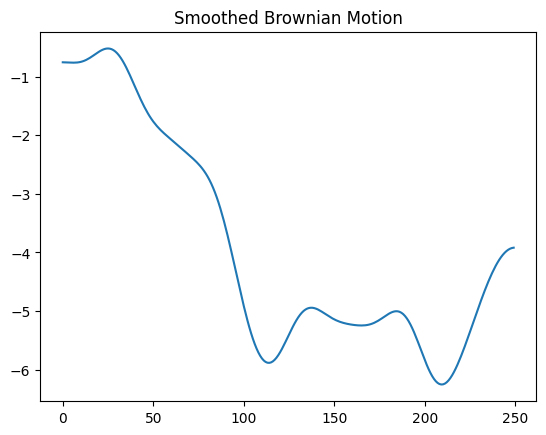

In [ ]:
def reconstruct_from_pendulum_observables(observable, C):
    if len(observable.shape) == 1:
        observable = observable.reshape((1, observable.shape[0]))
    
    xs = einops.einsum(observable, C, 'n z, x z->n x')
    return xs.squeeze()

def compute_Cx(nx, nz):
    C = np.zeros((nx, nz))
    C[:, :nx] = np.eye(nx)
    return C

def generate_random_smooth_controls(N, T):
    dt = 0.1
    w = np.random.randn(N, T, 1) * np.sqrt(dt)
    b = np.cumsum(w, axis=1)
    b_smooth = gaussian_filter1d(b, sigma=10, axis=1)
    
    return b_smooth

u = generate_random_smooth_controls(32, 250)
u_sample = u[0, :, 0]
plt.plot(u_sample)
plt.title("Smoothed Brownian Motion")
plt.show()

In [ ]:
# Test DMD method on linear system with known matrix
K = np.random.rand(3,3)
K = K.T @ K

N = 10
X = np.empty((N, 2, 3))
xs = np.random.rand(N, 3)
ys = xs @ K.T

pairs = np.stack([xs, ys], axis=0)
pairs = einops.rearrange(pairs, 'p n x -> n p x')

A, B = pairs[:, 0, :].T, pairs[:, 1, :].T

K_est = B @ np.linalg.pinv(A)
print("K estimated:\n", K_est)
print("K true:\n", K)

K estimated:
 [[1.16695498 1.00619392 0.91833694]
 [1.00619392 1.1017886  0.58798096]
 [0.91833694 0.58798096 0.95629479]]
K true:
 [[1.16695498 1.00619392 0.91833694]
 [1.00619392 1.1017886  0.58798096]
 [0.91833694 0.58798096 0.95629479]]


Simulation progress: 100%|██████████| 250/250 [00:00<00:00, 12020.41it/s]


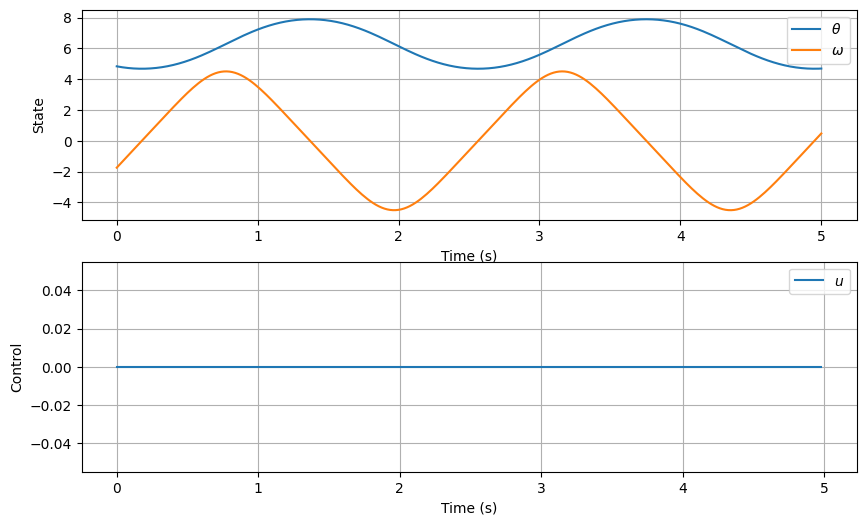

In [11]:
# Run a simulation with a pendulum
pendulum = Pendulum(Pendulum.Params(m=1, l=1, g=9.81))

N = 1_000
theta0 = np.random.uniform(0, 2*np.pi, (N, 1))
omega0 = np.random.uniform(-5.0, 5.0, (N, 1))
x0 = np.hstack((theta0, omega0))
tf = 5.0
dt = 0.02

smooth_controls = np.clip(generate_random_smooth_controls(N, int(tf/dt)), -3.0, 3.0)

def u(t, xs):
    return np.zeros((N, Pendulum.nu)) #smooth_controls[:, int(t/dt), :]

ts, xhist, uhist = simulate_batch(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=u,
    x0=x0
)

# Visualize a random trajectory
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(ts, xhist[0, :, 0], label=r'$\theta$')
ax[0].plot(ts, xhist[0, :, 1], label=r'$\omega$')
ax[0].legend()
ax[0].grid(True)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('State')

ax[1].plot(ts[:-1], uhist[0, :, 0], label=r'$u$')
ax[1].legend()
ax[1].grid(True)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Control')
plt.show()

In [12]:
phis_hist = Pendulum.koopman_observables(xhist)
nz = Pendulum.nz

print("Shape of observables:", phis_hist.shape)

n_observables = phis_hist.shape[-1]
n_controls = uhist.shape[-1]

phis_curr = phis_hist[:, :-1, :]
us_curr = uhist[:, :, :]
phis_curr_and_us_curr = np.concatenate([phis_curr, us_curr], axis=-1)
phis_curr_and_us_curr = einops.rearrange(phis_curr_and_us_curr, 'n t o -> (n t) o').T

phis_next = phis_hist[:, 1:, :]
phis_next = einops.rearrange(phis_next, 'n t o -> (n t) o').T

A_lstsq = phis_curr_and_us_curr
B_lstsq = phis_next

KB = B_lstsq @ np.linalg.pinv(A_lstsq)
K = KB[:, :n_observables]
B = KB[:, n_observables:]
Cx = compute_Cx(Pendulum.nx, nz)

print("Condition # of K:", np.linalg.cond(K))
print("# of observables:", phis_hist.shape[-1])
print("K shape:", K.shape)
print("B shape:", B.shape)

Shape of observables: (1000, 251, 8)
Condition # of K: 1.9512642223873182
# of observables: 8
K shape: (8, 8)
B shape: (8, 1)


In [13]:
print(repr(K.tolist()))
print(repr(B.tolist()))

[[0.9999999986229904, 0.02000000063459884, -0.001961988268936078, 1.477077740867183e-09, 3.7258890638297137e-10, -1.307661163013733e-05, 7.10207956286907e-08, 4.9902721233168014e-11], [-1.9520302384020576e-07, 0.9999999642715783, -0.19619770857994076, 2.698042732569416e-07, 7.624242543021847e-08, -0.001960347713785379, 1.4192286110546075e-05, 2.834407796791378e-09], [1.9516681906674614e-06, 5.380673733649534e-06, 0.9999658771612912, -3.836872291584635e-06, -1.1894111190552674e-06, 0.019961849336841683, -0.00021687317685368816, 5.668058945652759e-08], [7.732300139636502e-05, -0.00012607780432801342, -0.00013788396831506723, 1.0000487099924187, -0.019965833672268195, 9.643669529654579e-05, 1.7616403556624536e-06, -0.00019410476265013893], [-0.007724335282369511, 0.012593587536406095, 0.013740008930036287, -0.004594070738117852, 0.9944481734973205, -0.009631881717370975, -0.00016895302722452781, 0.019373946300705675], [-1.1111756117115536e-05, 0.0015045054747285312, -0.0033932870513276804

In [17]:
# Take the simulated systems and roll it out with the learned Koopman operator
x0 = np.array([
    # np.random.uniform(0, 2*np.pi),
    # np.random.uniform(-10.0, 10.0)
    0.0,
    0.0
])

ts, xhist, uhist = simulate(
    sys=pendulum,
    tf=10.0,
    dt=0.02,
    u=lambda t, xs: np.zeros(1), #uhist_opt[int(t/0.02), :],
    x0=x0
)

xhist_pred = np.empty_like(xhist)
xhist_pred[0] = x0
phi_curr = Pendulum.koopman_observables(x0)

for i in range(len(ts) - 1):
    x_curr = xhist_pred[i]
    u_curr = uhist[i]
    
    phi_curr = Pendulum.koopman_observables(x_curr)
    phi_next = K @ phi_curr + B @ u_curr
    
    x_next = Cx @ phi_next
    xhist_pred[i+1] = x_next
    # phi_curr = phi_next

theta_error = angle_wrap(xhist_pred[:, 0] - xhist[:, 0])
omega_error = xhist_pred[:, 1] - xhist[:, 1]

print(f"Max theta prediction error: {np.max(np.abs(theta_error)):.4f}")
print(f"Max omega prediction error: {np.max(np.abs(omega_error)):.4f}")
# print(f"Max state prediction error: {max_pred_error:.4f}")

Simulation progress:   0%|          | 0/500 [00:00<?, ?it/s]

Simulation progress: 100%|██████████| 500/500 [00:00<00:00, 23361.13it/s]

Max theta prediction error: 0.0000
Max omega prediction error: 0.0000


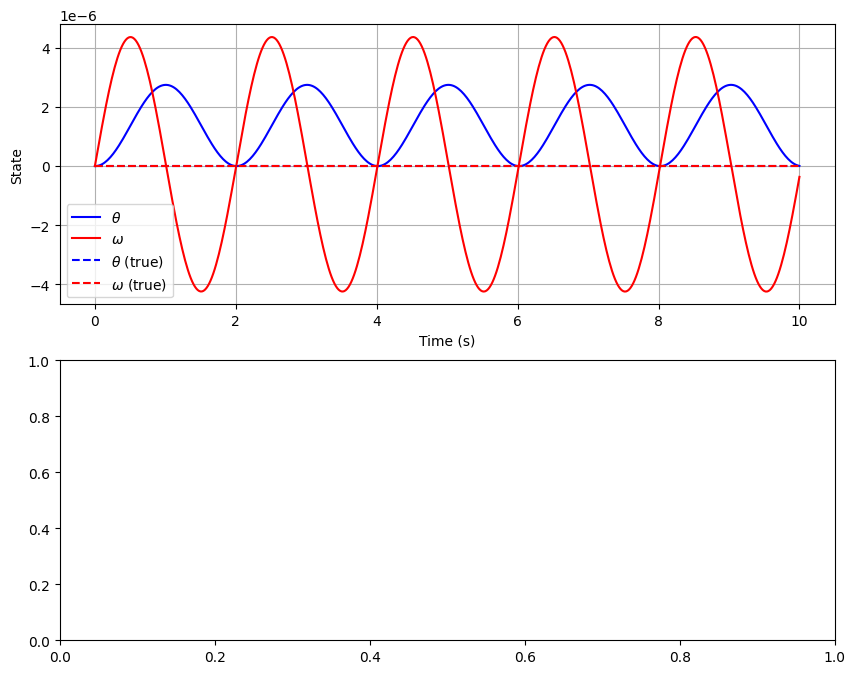

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(ts, xhist_pred[:, 0], label=r'$\theta$', c='blue')
ax[0].plot(ts, xhist_pred[:, 1], label=r'$\omega$', c='red')

ax[0].plot(ts, angle_wrap(xhist[:, 0], "0:2pi"), '--', label=r'$\theta$ (true)', c='blue')
ax[0].plot(ts, xhist[:, 1], '--', label=r'$\omega$ (true)', c='red')

ax[0].legend()
ax[0].grid(True)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('State')
plt.show()